# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [1]:
! git clone https://www.github.com/Sabrina-Hendricks/assignment4

Cloning into 'assignment4'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 17 (delta 3), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (17/17), 474.34 KiB | 4.16 MiB/s, done.
Resolving deltas: 100% (3/3), done.


**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

1.1 - Cleaning, handling outliers, badly-scaled variables

In [2]:
import numpy as  np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
df = pd.read_csv('/content/assignment4/data/cars_hw.csv');

In [4]:
df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [5]:
df.isnull().sum()

Unnamed: 0           0
Make                 0
Make_Year            0
Color                0
Body_Type            0
Mileage_Run          0
No_of_Owners         0
Seating_Capacity     0
Fuel_Type            0
Transmission         0
Transmission_Type    0
Price                0
dtype: int64

In [6]:
df['Age'] = max(df['Make_Year'])-df['Make_Year'] # Convert year to age

<Axes: xlabel='Age', ylabel='Price'>

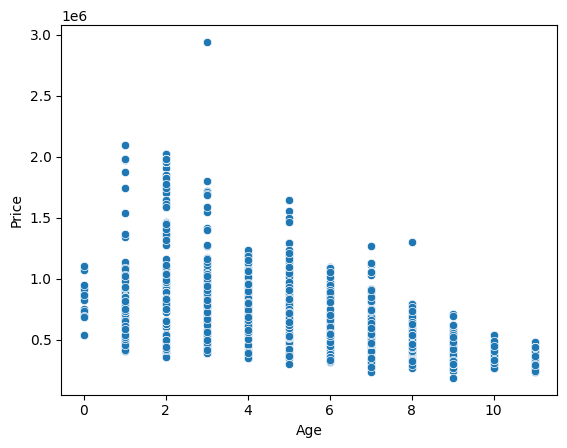

In [7]:
sns.scatterplot(data=df,y='Price',x='Age')

<Axes: xlabel='age_ihs', ylabel='price_ihs'>

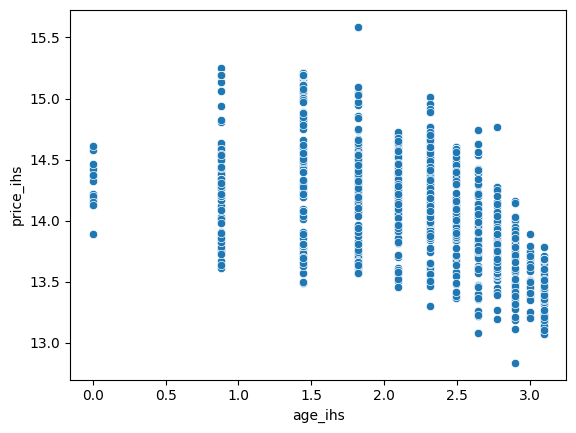

In [8]:
# Take arcsinh transformation to rescale the variables
df['price_ihs'] = np.arcsinh(df['Price'])
df['age_ihs'] = np.arcsinh(df['Age'])
sns.scatterplot(data=df,y='price_ihs',x='age_ihs')

<Axes: >

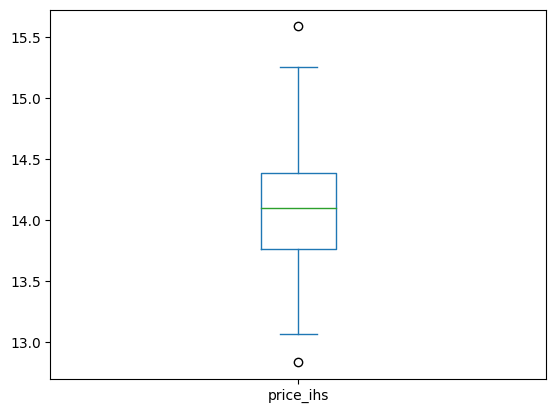

In [9]:
df['price_ihs'].plot.box()

<Axes: >

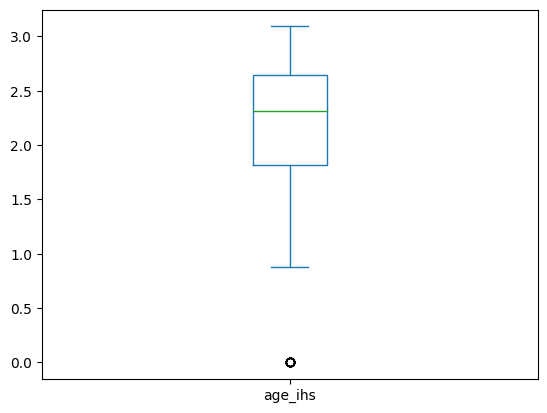

In [10]:
df['age_ihs'].plot.box()

In [11]:
# Drop outliers:
df = df.loc[df['price_ihs']>13,:]
df = df.loc[df['price_ihs']<15.5,:]
df = df.loc[df['age_ihs']>0,:]

<Axes: xlabel='age_ihs', ylabel='price_ihs'>

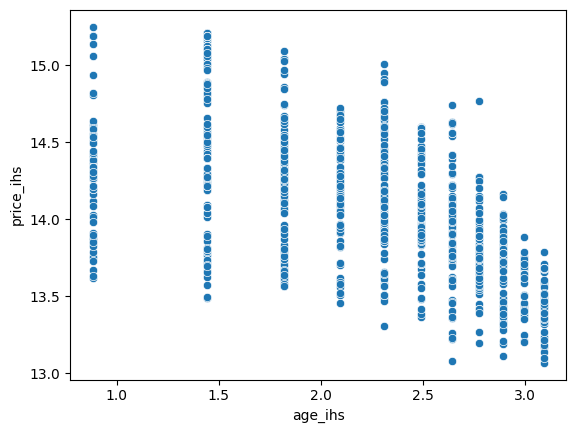

In [12]:
sns.scatterplot(data=df,y='price_ihs',x='age_ihs')

In [13]:
df['mileage_ihs'] = np.arcsinh(df['Mileage_Run']) #doing it for mileage too

In [14]:
#Make number of owners column numeric
df['No_of_Owners'] = df['No_of_Owners'].apply(lambda x: re.sub(r'\D', '', x))
df['No_of_Owners'] = pd.to_numeric(df['No_of_Owners'])


1.2 - Summarizing, kernel density plots

In [15]:
df['price_ihs'].describe()

count    960.000000
mean      14.101029
std        0.448406
min       13.068963
25%       13.757351
50%       14.095412
75%       14.383378
max       15.250595
Name: price_ihs, dtype: float64

<Axes: xlabel='price_ihs', ylabel='Density'>

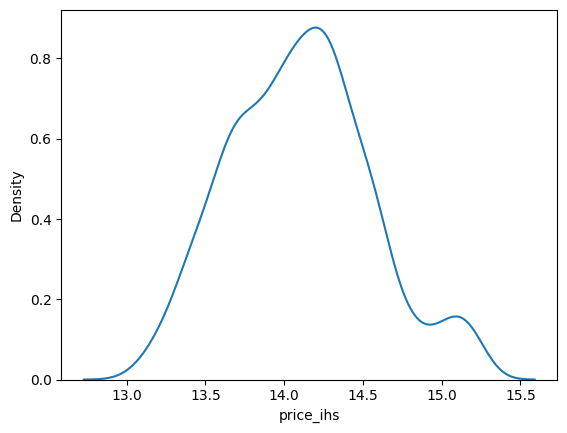

In [16]:
sns.kdeplot(data=df, x='price_ihs')

In [17]:
df.groupby('Make')['price_ihs'].describe()

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,13.613042,0.480975,13.188151,13.261539,13.445433,13.864828,14.394369
Datsun,3.0,13.269194,0.036311,13.232114,13.251449,13.270783,13.287734,13.304685
Ford,52.0,14.161427,0.210895,13.270783,14.054527,14.162640,14.269131,14.572571
Honda,73.0,14.229465,0.336972,13.356645,13.965653,14.266586,14.419827,14.938490
Hyundai,303.0,14.060094,0.399580,13.114331,13.784019,14.059241,14.330129,15.063692
Jeep,4.0,14.909738,0.105084,14.763300,14.876417,14.933413,14.966733,15.008827
Kia,8.0,14.985324,0.076877,14.822738,14.965389,14.996253,15.042662,15.063117
MG Motors,35.0,15.132199,0.066263,14.971763,15.088892,15.122762,15.190744,15.211260
Mahindra,18.0,14.592100,0.159906,14.280502,14.544955,14.598828,14.654396,14.890513


<Axes: xlabel='price_ihs', ylabel='Density'>

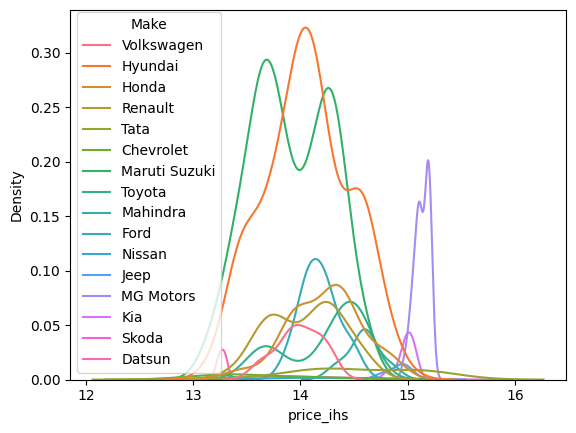

In [18]:
sns.kdeplot(data=df, x='price_ihs', hue='Make')

The most expensive carbrands are MG Motors, Kia, Jeep, Mahindra, and Tata. Prices within each brand show varying degrees of consistency, with some brands having relatively stable prices (e.g., Datsun, Kia, MG Motors) and others showing more variability (e.g., Nissan, Tata, Skoda, Chevrolet). Most car brands have around a similar mean ihs price.

1.3 - Splitting the sample

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
y = df['price_ihs'] # Create target variable vector
X = df.loc[:,['age_ihs','Color', 'Seating_Capacity', 'Body_Type', 'Make', 'mileage_ihs', 'Fuel_Type', 'Transmission', 'Transmission_Type']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

1.4 - Linear Models

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [23]:
y = df['price_ihs'] # Create target variable vector
X = df.loc[:,['age_ihs', 'Seating_Capacity', 'mileage_ihs']] #only numeric variables
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

In [32]:
reg = LinearRegression().fit(X_train,y_train) # Fit the linear model
print(reg.intercept_) # Intercept value
print(reg.coef_) # Regression coefficients
print("R squared:", reg.score(X_test, y_test)) # R squared measure

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

12.698016807932134
[-0.55369073  0.08912432  0.19333662]
R squared: 0.3599501825434104
Root Mean Square Error (RMSE): 0.349764389147041


In [34]:
#One-hot encoding for categorical variables
from sklearn.preprocessing import LabelBinarizer
one_hot_encoder = LabelBinarizer()

In [38]:
Color = pd.get_dummies(df['Color'],dtype='int')
oh = one_hot_encoder.fit_transform(df['Color']) # One-hot encode the 'bird' variable
names = one_hot_encoder.classes_ # Get names of the classes
ColorDF = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables
ColorDF.head()

,beige,black,blue,bronze,brown,golden,green,grey,maroon,orange,purple,red,silver,white,yellow
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [39]:
Body_Type = pd.get_dummies(df['Body_Type'],dtype='int')
oh = one_hot_encoder.fit_transform(df['Body_Type']) # One-hot encode the 'bird' variable
names = one_hot_encoder.classes_ # Get names of the classes
Body_TypeDF = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables
Body_TypeDF.head()

,crossover,hatchback,muv,sedan,suv
0,0,0,0,1,0
1,1,0,0,0,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0


In [40]:
Make = pd.get_dummies(df['Make'],dtype='int')
oh = one_hot_encoder.fit_transform(df['Make']) # One-hot encode the 'bird' variable
names = one_hot_encoder.classes_ # Get names of the classes
MakeDF = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables
MakeDF.head()

,Chevrolet,Datsun,Ford,Honda,Hyundai,Jeep,Kia,MG Motors,Mahindra,Maruti Suzuki,Nissan,Renault,Skoda,Tata,Toyota,Volkswagen
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [41]:
Fuel_Type = pd.get_dummies(df['Fuel_Type'],dtype='int')
oh = one_hot_encoder.fit_transform(df['Fuel_Type']) # One-hot encode the 'bird' variable
names = one_hot_encoder.classes_ # Get names of the classes
Fuel_TypeDF = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables
Fuel_TypeDF.head()

,diesel,petrol,petrol+cng
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [42]:
Transmission = pd.get_dummies(df['Transmission'],dtype='int')
oh = one_hot_encoder.fit_transform(df['Transmission']) # One-hot encode the 'bird' variable
names = one_hot_encoder.classes_ # Get names of the classes
TransmissionDF = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables
TransmissionDF.head()

,4-Speed,5-Speed,6-Speed,7-Speed,CVT
0,0,0,0,1,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [107]:
# Concatenate:
X_categ = pd.concat([ColorDF,Body_TypeDF, MakeDF, Fuel_TypeDF, TransmissionDF],axis=1) # Concatenate engineered features
y = df['price_ihs']
X_categ.head()

,beige,black,blue,bronze,brown,golden,green,grey,maroon,orange,...,Toyota,Volkswagen,diesel,petrol,petrol+cng,4-Speed,5-Speed,6-Speed,7-Speed,CVT
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_categ,y,test_size=.2,random_state=100)

In [109]:
reg = LinearRegression().fit(X_train,y_train) # Fit the linear model
print("R squared:", reg.score(X_test, y_test)) # R squared measure

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: 0.6217457058186538
Root Mean Square Error (RMSE): 0.2688813219919555


The categorical model performs better on the test set. It has a larger R^2, so the model is more predictive. It also has a smaller RMSE, meaning there is less error between the train and test set.

In [88]:
# Concatenate numerical and categorical features
X_combined = pd.concat([X, df[['age_ihs', 'Seating_Capacity', 'mileage_ihs']]], axis=1)

# Concatenate numerical and categorical features
X_combined = pd.concat([X, df[['age_ihs', 'Seating_Capacity', 'mileage_ihs']]], axis=1)

# Align indices of X_combined and y
X_combined = X_combined.loc[y.index]

from sklearn.impute import SimpleImputer

# Create an imputer instance
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'constant' strategy

# Fit and transform the imputer on your X_combined dataset
X_combined_imputed = imputer.fit_transform(X_combined)

# Split the combined data into training and testing sets
X_combined_train, X_combined_test, y_train, y_test = train_test_split(X_combined_imputed, y, test_size=.2, random_state=100)

# Fit the combined linear model
reg_combined = LinearRegression().fit(X_combined_train, y_train)


# Evaluate the combined model
print("R squared (Combined Model):", reg_combined.score(X_combined_test, y_test))  # R squared measure

y_pred_combined = reg_combined.predict(X_combined_test)
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
print("Root Mean Square Error (RMSE) (Combined Model):", rmse_combined)



R squared (Combined Model): 0.34965214039594295
Root Mean Square Error (RMSE) (Combined Model): 0.3525669176583974


The joint model performs worse than the other two models. It performs significantly worse than the categorical model and not much worse than the numerical.

1.5 - Polynomial Features - only do this on the numeric variables

In [89]:
from sklearn.preprocessing import PolynomialFeatures

In [103]:
expander = PolynomialFeatures(degree=1,include_bias=False) # Create the expander
Z = expander.fit_transform(X_combined_imputed) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

X_train, X_test, y_train, y_test = train_test_split(zdf,y,test_size=.2,random_state=100)
reg = LinearRegression().fit(X_train,y_train) # Fit the linear model
print("R squared:", reg.score(X_test, y_test)) # R squared measure

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: 0.34965214039594295
Root Mean Square Error (RMSE): 0.3525669176583974


In [104]:
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_combined_imputed) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

X_train, X_test, y_train, y_test = train_test_split(zdf,y,test_size=.2,random_state=100)
reg = LinearRegression().fit(X_train,y_train) # Fit the linear model
print("R squared:", reg.score(X_test, y_test)) # R squared measure

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: -4.3381141153481235e+20
Root Mean Square Error (RMSE): 9105822644.119486


In [105]:
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
Z = expander.fit_transform(X_combined_imputed) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

X_train, X_test, y_train, y_test = train_test_split(zdf,y,test_size=.2,random_state=100)
reg = LinearRegression().fit(X_train,y_train) # Fit the linear model
print("R squared:", reg.score(X_test, y_test)) # R squared measure

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: -1.5909747548958107e+20
Root Mean Square Error (RMSE): 5514426409.576787


As you increase the degree of expansion, the absolute value of R squared increases, but its actual value decreases.  This means it is a worse model. Similarly, the RMSE increases, indicating it is a worse model. Going from a degree of 1 to a degree of 2 is when the R2 became negative. The best model with expanded features was with a degree of 3, which is significantly worse than my best model above. From my analysis and models above, it is best to not use any degrees of expansion.

1.6 - Predicted vs. True values and Model Evaluation

In [110]:
#Best model so far - categorical only
X_train, X_test, y_train, y_test = train_test_split(X_categ,y,test_size=.2,random_state=100)

reg = LinearRegression().fit(X_train,y_train) # Fit the linear model
print("R squared:", reg.score(X_test, y_test)) # R squared measure

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: 0.6217457058186538
Root Mean Square Error (RMSE): 0.2688813219919555


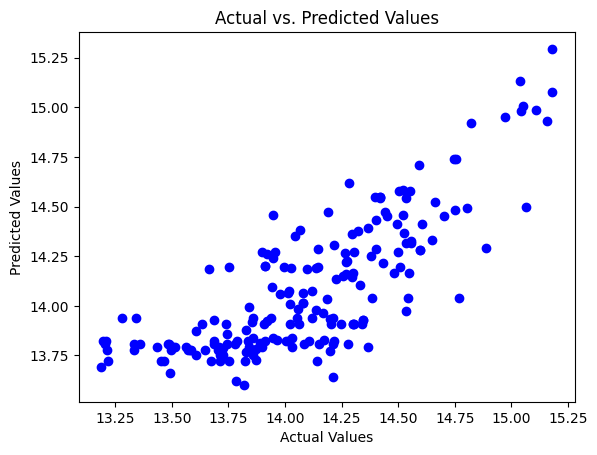

In [112]:
#Plot test against predicted values
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

The predicted versus true values do roughly line up along the diaganol y=x line, as shown in the diagram above.

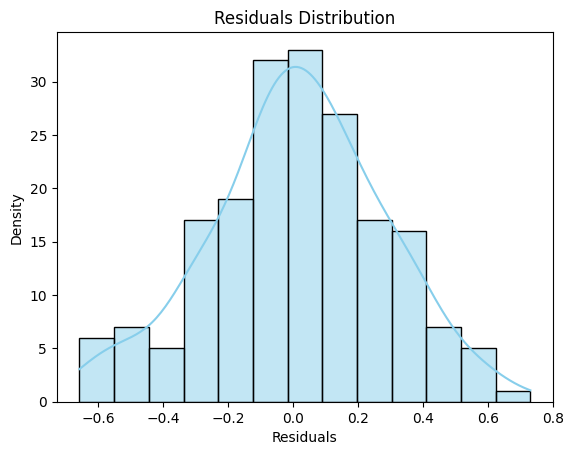

In [115]:
# Compute residuals
residuals = y_test - y_pred

sns.histplot(residuals, kde=True, color='skyblue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

The residuals do look roughly bell-shaped around 0.

The strengths of this model are that a significant portion of the variability in the data is captured by the model, indicated by an R-squared value of 0.622. In addition, the lower RMSE value suggest that the model's predictions are relatively close to the actual values, also supported by the plot of actual vs predicted values. And even further, the bell-shaped distribution of residuals around 0 suggests that the errors are normally distributed. This is a good sign as it indicates that the model is capturing the underlying patterns in the data and the errors are not biased in any particular direction.

The weaknesses of this model are that there might be other unaccounted factors or non-linear relationships in the data that the model is not capturing, as the R-squared value is 0.622. In addition, while the RMSE is small, there is room for improvement. Generally speaking, as noted before, linear regression assumes a linear relationship between predictors and the target variable. If the relationship is non-linear, the model might not capture it accurately.

1.7 - Regression Trees

In [117]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [131]:
# Selecting relevant features (excluding target variable 'price_ihs' and its components)
X = df[['Make', 'Make_Year', 'Color', 'Body_Type', 'mileage_ihs',
        'No_of_Owners', 'Seating_Capacity', 'Fuel_Type',
        'Transmission', 'Transmission_Type', 'age_ihs']]
X_categ = pd.get_dummies(X, columns=['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type'])
y = df['price_ihs']

X_train, X_test, y_train, y_test = train_test_split(X_categ, y, test_size=.2, random_state=100)

reg = DecisionTreeRegressor(max_depth=2, random_state=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R squared:", reg.score(X_test, y_test)) # R squared measure
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: 0.5506282414219108
Root Mean Square Error (RMSE): 0.2930701514255254


In [123]:
reg = DecisionTreeRegressor(max_depth=5, random_state=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R squared:", reg.score(X_test, y_test)) # R squared measure
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: 0.7037522857546743
Root Mean Square Error (RMSE): 0.237955750895856


In [124]:
reg = DecisionTreeRegressor(max_depth=10, random_state=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R squared:", reg.score(X_test, y_test)) # R squared measure
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: 0.7612286193979063
Root Mean Square Error (RMSE): 0.2136288174603878


In [125]:
reg = DecisionTreeRegressor(max_depth=15, random_state=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R squared:", reg.score(X_test, y_test)) # R squared measure
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: 0.7686680297308504
Root Mean Square Error (RMSE): 0.21027446155842966


In [126]:
reg = DecisionTreeRegressor(max_depth=20, random_state=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R squared:", reg.score(X_test, y_test)) # R squared measure
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

R squared: 0.7497186663413049
Root Mean Square Error (RMSE): 0.21871719696808764


The tree with depth 15 gives the best results. It has the highest R squared and lowest RMSE. When increasing from there, however, the models become worse.

1.8 - Model Evaluation for Trees

R squared: 0.7686680297308504
Root Mean Square Error (RMSE): 0.21027446155842966


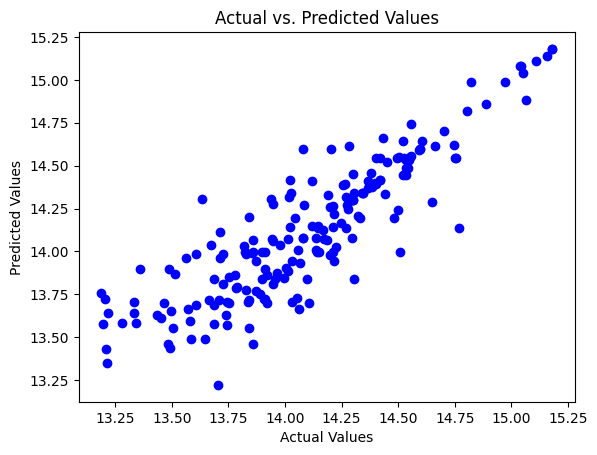

In [127]:
reg = DecisionTreeRegressor(max_depth=15, random_state=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R squared:", reg.score(X_test, y_test)) # R squared measure
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Square Error (RMSE):", rmse)

#Plot test against predicted values for best model
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

Yes, the predicted values and true values do line up along the diagonal. Very well actually.

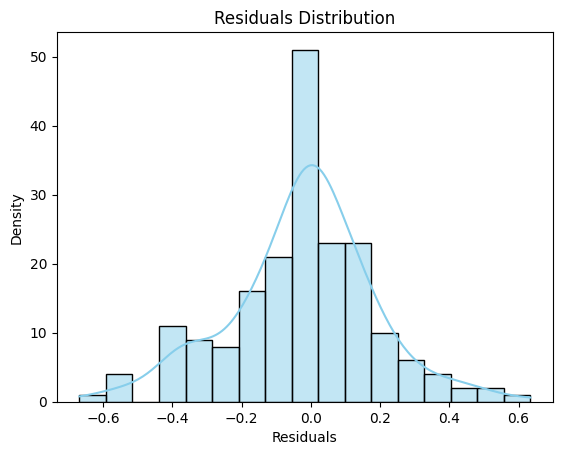

In [128]:
# Compute residuals
residuals = y_test - y_pred

sns.histplot(residuals, kde=True, color='skyblue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

Yes, the residuals do look roughly bell-shaped around 0.

1.9 - Linear Model vs Tree

The classification and regression tree has better performance on the test set. It has a higher R squared, lower RMSE, and the actual vs. predicted plot shows it provides more accurate results. In addition, its residuals are also roughly bell-shaped around 0.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

3.1 - Loading, Tabulation

In [162]:
data = pd.read_csv('/content/assignment4/data/contraception_hw.csv');
data.head()

,Unnamed: 0,age,edu,edu_spouse,numberChildren,religion,working,spouse_occupation,standardOfLivingIndex,mediaExposure,method
0,1,24,2,3,3,1,1,2,3,0,1
1,2,45,1,3,10,1,1,3,4,0,1
2,3,43,2,3,7,1,1,3,4,0,1
3,4,42,3,2,9,1,1,3,3,0,1
4,5,36,3,3,8,1,1,3,2,0,1


In [163]:
data['method'].value_counts()

1    629
3    511
2    333
Name: method, dtype: int64

In [164]:
pd.crosstab(data['method'], data['numberChildren'])

numberChildren,0,1,2,3,4,5,6,7,8,9,10,11,12,13,16
method,,,,,,,,,,,,,,,
1,95,143,114,70,57,44,35,18,29,5,9,6,4,0,0
2,0,46,56,70,62,36,27,19,9,3,2,2,0,1,0
3,2,87,106,119,78,55,30,12,9,8,0,3,0,1,1


Couples that don't use birth control tend to have 0 children more frequently than couples who do use birth control. That being said, they tend to have more children as the numbers of children increase than those who use birth control.

3.2 - Splitting the sample

In [173]:
y = data['method'] # Create target variable vector
X = data.drop(['method'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

3.3 - Bad regression tree

[Text(0.4230769230769231, 0.875, 'x[3] <= 0.5\nsquared_error = 0.765\nsamples = 1178\nvalue = 1.919'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 17.5\nsquared_error = 0.104\nsamples = 75\nvalue = 1.053'),
 Text(0.07692307692307693, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 3.0'),
 Text(0.23076923076923078, 0.375, 'x[6] <= 3.5\nsquared_error = 0.053\nsamples = 74\nvalue = 1.027'),
 Text(0.15384615384615385, 0.125, 'squared_error = 0.0\nsamples = 70\nvalue = 1.0'),
 Text(0.3076923076923077, 0.125, 'squared_error = 0.75\nsamples = 4\nvalue = 1.5'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 37.5\nsquared_error = 0.756\nsamples = 1103\nvalue = 1.978'),
 Text(0.5384615384615384, 0.375, 'x[3] <= 2.5\nsquared_error = 0.758\nsamples = 783\nvalue = 2.115'),
 Text(0.46153846153846156, 0.125, 'squared_error = 0.786\nsamples = 382\nvalue = 1.955'),
 Text(0.6153846153846154, 0.125, 'squared_error = 0.684\nsamples = 401\nvalue = 2.267'),
 Text(0.8461538461538461, 0.375, 'x[1] <= 2.5\nsquared

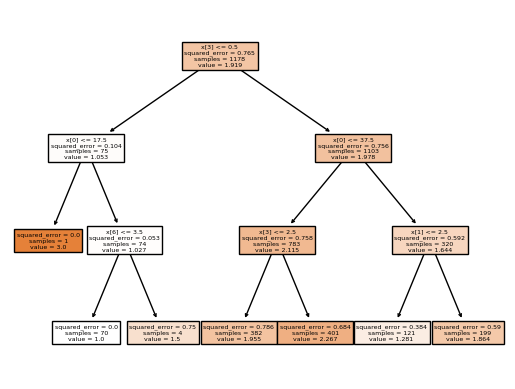

In [175]:
y = data['method'] # Create target variable vector
X = data.drop(['method', 'Unnamed: 0'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

reg = DecisionTreeRegressor(max_depth=3, random_state=100)
reg.fit(X_train, y_train)

# Visualize results:
tree.plot_tree(reg,filled=True)

The terminal nodes has values such as "1.5", "2.267", and "1.251" which do not make sense. This is because we expect the predicted values to be discrete values, representative of the contraceptive method used where 1=No-use, 2=Long-term, and 3=Short-termhort-term. It doesn't make sense to have the values in the terminal nodes in this scenario, as they are not possible outcomes. Using a regression tree does not make sense when we want to have a categorical outcome.

3.4 - Classification Tree

[Text(0.4230769230769231, 0.875, 'x[3] <= 0.5\ngini = 0.647\nsamples = 1178\nvalue = [502, 269, 407]'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 17.5\ngini = 0.052\nsamples = 75\nvalue = [73, 0, 2]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.23076923076923078, 0.375, 'x[6] <= 3.5\ngini = 0.027\nsamples = 74\nvalue = [73, 0, 1]'),
 Text(0.15384615384615385, 0.125, 'gini = 0.0\nsamples = 70\nvalue = [70, 0, 0]'),
 Text(0.3076923076923077, 0.125, 'gini = 0.375\nsamples = 4\nvalue = [3, 0, 1]'),
 Text(0.6923076923076923, 0.625, 'x[1] <= 2.5\ngini = 0.654\nsamples = 1103\nvalue = [429, 269, 405]'),
 Text(0.5384615384615384, 0.375, 'x[0] <= 37.5\ngini = 0.562\nsamples = 367\nvalue = [207, 39, 121]'),
 Text(0.46153846153846156, 0.125, 'gini = 0.592\nsamples = 246\nvalue = [109, 27, 110]'),
 Text(0.6153846153846154, 0.125, 'gini = 0.326\nsamples = 121\nvalue = [98, 12, 11]'),
 Text(0.8461538461538461, 0.375, 'x[0] <= 32.5\ngini = 0.662\nsamples

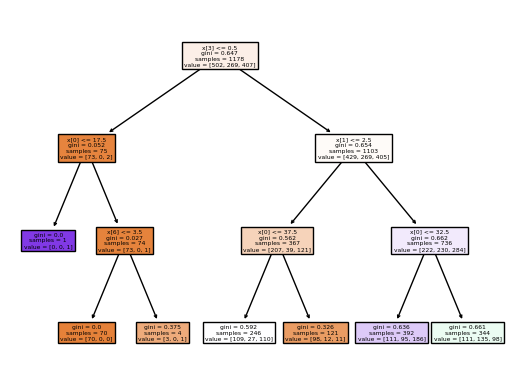

In [188]:
y = data['method'] # Create target variable vector
X = data.drop(['method', 'Unnamed: 0'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

# Fit decision tree:
cart = tree.DecisionTreeClassifier(max_depth = 3) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

# Visualize results:
tree.plot_tree(cart,filled=True)

In [170]:
X.columns

Index(['age', 'edu', 'edu_spouse', 'numberChildren', 'religion', 'working',
       'spouse_occupation', 'standardOfLivingIndex', 'mediaExposure'],
      dtype='object')

This tree looks different from the previous in that it is using splits in the data to make the cuts, represented by the array given for values. This makes more sense for the type of prediction we are doing. The algorithm uses numberChildren, age, and education. People with a small number of children are most likely to opt for no contraception. People with more children and lower education are more inclined towards long-term contraception methods. This suggests that individuals with relatively higher family size and lower education levels tend to opt for long-term contraception solutions. Additionally, people with more children and higher education are likely to use short-term contraception methods. Among individuals with more children, those who are older are also inclined towards short-term contraception.

3.5 - Confusion matrix and accuracy

In [189]:
y_hat = cart.predict(X_test)

In [190]:
tab = pd.crosstab(y_test,y_hat)
tab

col_0,1,2,3
method,,,
1,40,37,50
2,3,38,23
3,4,30,70


In [198]:
accuracy = (tab.iloc[0, 0] + tab.iloc[1, 1] + tab.iloc[2, 2]) / (np.sum(tab.iloc[0, :]) + np.sum(tab.iloc[1, :]) + np.sum(tab.iloc[2, :]))
print("Accuracy for overall model:", accuracy)

Accuracy for overall model: 0.5016949152542373


In [195]:
method_1_accuracy = tab.iloc[0, 0] / np.sum(tab.iloc[0, :])
method_2_accuracy = tab.iloc[1, 1] / np.sum(tab.iloc[1, :])
method_3_accuracy = tab.iloc[2, 2] / np.sum(tab.iloc[2, :])

print("Accuracy for no contraception:", method_1_accuracy)
print("Accuracy for long-term:", method_2_accuracy)
print("Accuracy for short-term:", method_3_accuracy)

Accuracy for no contraception: 0.31496062992125984
Accuracy for long-term: 0.59375
Accuracy for short-term: 0.6730769230769231


3.6 - Linear probability explanation

 In classification problems such as this one, the relationship between predictors and the probability of class membership is often non-linear. Linear regression cannot capture these non-linear patterns effectively, leading to inaccurate predictions. The desired predicted variable is not numerical, so it does not make sense to use a linear prediction strategy. This was shown when I ran a regression tree, and it did not make sense.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?